# **Roadmap:**
### - [Setup](#Environment-setup-for-Kubeless-functions-and-Q-learning)
### - [Training algorithm](#Train-the-agent)
### - [Result plots](#Analyze-results)

# Environment setup for Kubeless functions and DQN

## Install the gym-k8s package that registers our environments

In [ ]:
!pip3 install -e ../../gym-k8s
!pip3 install matplotlib pandas seaborn tensorflow==2.4.1 tf-agents==0.7.1

In [ ]:
import functools
import json
import os
import random
import time
import uuid
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import parallel_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.system import multiprocessing
from tf_agents.utils import common

from gym_k8s.envs import K8sEnvContinuousStateDiscreteActionV1

In [ ]:
multiprocessing.enable_interactive_mode()

## Info of the Kubeless app we want to deploy

In [ ]:
# Timestep duration in minutes
# We wait these many minutes for our actions to be enforced
timestep_duration = 6
app_name = 'fibonacci'
input_file = '~/serverless-elasticity-management/examples/kubeless/fibonacci-python/app.py'
handler_fun = 'app.fibonacci'
memory_req = '128Mi'
cpu_req = '80m'
sla_latency = 0.25
prometheus_host = 'http://localhost:9090/'
# Nginx ingress latency metric
prometheus_latency_metric_name = '(sum(rate(nginx_ingress_controller_request_duration_seconds_sum'\
    '{{ingress="{0}", status="200"}}[{1}m])) by (ingress))'\
    '/(sum(rate(nginx_ingress_controller_request_duration_seconds_count'\
    '{{ingress="{0}", status="200"}}[{1}m])) by (ingress))'.format(app_name, timestep_duration)

## Training parameters

In [ ]:
train_dir = os.path.join(os.getcwd(), 'train_dir/')
total_epochs = 8000
steps_per_epoch = 4
num_of_services = 12
total_steps_per_epoch = steps_per_epoch * num_of_services
initial_collect_epochs = 100
initial_collect_checkpoint_interval = 10
# Intervals in train steps
train_checkpoint_interval = 2
policy_checkpoint_interval = 2
rb_checkpoint_interval = 2
eval_interval = 10
eval_epochs = 3
use_tf_functions = True

## Hyperparameters

In [ ]:
learning_rate = 1e-3
gamma = 0.9
epsilon_greedy = 0.8
batch_size = 64
replay_buffer_max_length = 100000
target_update_tau = 0.05
target_update_period = 5

## Create historical states csv file if it doesn't exist

In [ ]:
try:
    open('k8s_historical_states_discrete.csv', 'r').close()
    print('File already present.')
except IOError:
    with open('k8s_historical_states_discrete.csv', 'w') as f:
        f.write('current_timestep,action,reward,done,'
                'current_replicas,pods_backoff,pod_cpu_util,'
                'latency_violation,latency,cpu_threshold'
                '\n'
        )
    print('File not present. Created successfully!')

# Train the agent

Create a Kubeless environment subclass that will handle the creation, deletion and stress loading of our application:

In [ ]:
class SimulatedEnv(K8sEnvContinuousStateDiscreteActionV1):
    def __init__(self,
                 timestep_duration,
                 app_name,
                 sla_latency,
                 prometheus_host,
                 prometheus_latency_metric_name,
                 input_file,
                 handler_fun,
                 memory_req,
                 cpu_req,
                 max_episode_steps,
                 cpu_thresh_init):

        with open('../kubeless-env-discrete-state-discrete-action-V5/old-outputs/06/distributions.json') as f:
            self.distributions = json.load(f)

        self.cpu_thresh_init = cpu_thresh_init
        self.cpu_min_thresh = 20
        self.cpu_max_thresh = 100
        self.threshold_step = 20
        self.possible_thresholds = list(
                range(self.cpu_min_thresh, self.cpu_max_thresh + 1, self.threshold_step)
        )
        self.steps = 0
        self.max_episode_steps = max_episode_steps
        self.timestep_duration = timestep_duration
        self.input_file = input_file
        self.handler_fun = handler_fun
        self.memory_req = memory_req
        self.cpu_req = cpu_req
        service_id = uuid.uuid4()
        self.current_app_name = '{}{}'.format(app_name, service_id)
        self.endpoint = 'kubeless-{}-python.default.127.0.0.1.nip.io:8000'.format(self.current_app_name)

        current_latency_metric_name = prometheus_latency_metric_name.replace(app_name, self.current_app_name)

        super().__init__(
            timestep_duration=timestep_duration,
            app_name=self.current_app_name,
            sla_latency=sla_latency,
            prometheus_host=prometheus_host,
            prometheus_latency_metric_name=current_latency_metric_name,
            cpu_thresh_init=cpu_thresh_init
        )

    def step(self, action):
        base_rate = 0.5
        stress_timesteps_dict = {
            base_rate: {0, 3},
            7 * base_rate: {1, 2}
        }
        
        # Loop through dictionary and find the current stress rate
        for stress_rate in stress_timesteps_dict:
            if self.steps in stress_timesteps_dict[stress_rate]:
                self.current_stress = str(stress_rate)

        if action == 0 and self.current_cpu_thresh > self.cpu_min_thresh:
            self.current_cpu_thresh -= self.threshold_step

        if action == 2 and self.current_cpu_thresh < self.cpu_max_thresh:
            self.current_cpu_thresh += self.threshold_step

        (pod_cpu_current_util,
         current_replicas,
         latency) = self._simulate_metrics()

        pod_cpu_threshold = self.current_cpu_thresh
        pods_backoff = 0

        observation = [
            pod_cpu_current_util,
            pod_cpu_threshold,
            current_replicas,
            pods_backoff,
            latency
        ]
        reward = super()._get_reward(observation)

        self.steps += 1
        if self.steps % self.max_episode_steps == 0:
            self.steps = 0

        info = ''
        return observation, reward, self.done, info

    def reset(self):
        self.steps = 0

        if self.cpu_thresh_init is not None:
            self.current_cpu_thresh = self.cpu_thresh_init
        else:
            self.current_cpu_thresh = random.choice(self.possible_thresholds)

        pod_cpu_current_util = 0
        pod_cpu_threshold = 0
        current_replicas = self.MAX_PODS
        pods_backoff = 0
        latency = 100 * self.sla_latency

        init_observation = [
            pod_cpu_current_util,
            pod_cpu_threshold,
            current_replicas,
            pods_backoff,
            latency
        ]

        return init_observation

    def _simulate_metrics(self):
        replicas_mean = float(self.distributions[self.current_stress]['thresh'][str(self.current_cpu_thresh)]['replicas_mean'])
        replicas_std = float(self.distributions[self.current_stress]['thresh'][str(self.current_cpu_thresh)]['replicas_std'])
        current_replicas = round(random.gauss(replicas_mean, replicas_std))
        
        cpu_util_mean = float(self.distributions[self.current_stress]['pod'][str(current_replicas)]['cpu_util_mean'])
        cpu_util_std = float(self.distributions[self.current_stress]['pod'][str(current_replicas)]['cpu_util_std'])
        pod_cpu_current_util = random.gauss(cpu_util_mean, cpu_util_std)
        
        latency_mean = float(self.distributions[self.current_stress]['pod'][str(current_replicas)]['latency_mean'])
        latency_std = float(self.distributions[self.current_stress]['pod'][str(current_replicas)]['latency_std'])
        latency = random.gauss(latency_mean, latency_std)

        simulated_metrics = [
            pod_cpu_current_util,
            current_replicas,
            latency
        ]
        return simulated_metrics

Create callable function to pass to the ParallelPyEnvironment constructor:

In [ ]:
def create_py_env(cpu_thresh_init=None):
    env = SimulatedEnv(
        timestep_duration,
        app_name,
        sla_latency,
        prometheus_host,
        prometheus_latency_metric_name,
        input_file,
        handler_fun,
        memory_req,
        cpu_req,
        steps_per_epoch,
        cpu_thresh_init
    )
    py_env = suite_gym.wrap_env(env)
    return py_env

## Agent training
The global step variable tracks how many times we've run our train function on the agent:

In [ ]:
global_step = tf.compat.v1.train.get_or_create_global_step()

Create `num_of_services` parallel environments for training. The batch size for the underlying PyEnvironment becomes equal to `num_of_services`. For example for 15 services, the environment takes one action for each and treats all 15 actions as a batch. We use this batch size when we instantiate our replay buffer:

In [ ]:
train_py_env = parallel_py_environment.ParallelPyEnvironment([create_py_env] * num_of_services)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

# 5 parallel evaluation environments
eval_env_constructors = [functools.partial(create_py_env, cpu_thresh_init=thresh) for thresh in range(20, 100 + 1, 20)]
eval_envs_num = len(eval_env_constructors)
eval_py_env = parallel_py_environment.ParallelPyEnvironment(eval_env_constructors)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

Environment information:

In [ ]:
print('action_spec:', train_env.action_spec())
print('time_step_spec.observation:', train_env.time_step_spec().observation)
print('time_step_spec.step_type:', train_env.time_step_spec().step_type)
print('time_step_spec.discount:', train_env.time_step_spec().discount)
print('time_step_spec.reward:', train_env.time_step_spec().reward)

Create Q Network and DQN Agent:

In [ ]:
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(100,)
)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy=epsilon_greedy,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=global_step,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    gamma=gamma
)

agent.initialize()

eval_policy = agent.policy
collect_policy = agent.collect_policy

Create a replay buffer where we collect training data:

In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length
)

Create a driver that runs a total of `num_steps` in our train env each time we call its `run` function:

In [ ]:
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=total_steps_per_epoch
)

Create checkpointers that will periodically save our agent, policy and replay buffer to disk:

In [ ]:
train_checkpointer = common.Checkpointer(
    ckpt_dir=train_dir,
    agent=agent,
    global_step=global_step
)

policy_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(train_dir, 'policy'),
    policy=eval_policy,
    global_step=global_step
)

rb_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(train_dir, 'replay_buffer'),
    max_to_keep=1,
    replay_buffer=replay_buffer
)

train_checkpointer.initialize_or_restore()
rb_checkpointer.initialize_or_restore();

Collect initial buffer experience:

In [ ]:
initial_collect_step = tf.Variable(0, trainable=False)

initial_collect_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(train_dir, 'initial_collect'),
    initial_collect_step=initial_collect_step
)

initial_collect_checkpointer.initialize_or_restore()

initial_collect_policy = random_tf_policy.RandomTFPolicy(
    train_env.time_step_spec(),
    train_env.action_spec()
)

initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=total_steps_per_epoch
)

if use_tf_functions:
    initial_collect_driver.run = common.function(initial_collect_driver.run)

while True:
    print('Collect step: {}'.format(initial_collect_step.numpy()))

    if initial_collect_step.numpy() == initial_collect_epochs:
        break

    initial_collect_driver.run()
    initial_collect_step = tf.add(initial_collect_step, 1)

    if initial_collect_step.numpy() % initial_collect_checkpoint_interval == 0:
        rb_checkpointer.save(global_step=initial_collect_step.numpy())
        initial_collect_checkpointer.save(global_step=initial_collect_step.numpy())

In [ ]:
if use_tf_functions:
    # To speed up collect use common.function.
    collect_driver.run = common.function(collect_driver.run)
    agent.train = common.function(agent.train)

time_step = None
policy_state = collect_policy.get_initial_state(train_env.batch_size)

# If num_steps is not set, the dataset returns states and not transitions
# from state to state. So we set it to equal 2 aka a transition from one state to another
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)
iterator = iter(dataset)

def train_step():
    experience, _ = next(iterator)
    return agent.train(experience)

if use_tf_functions:
    train_step = common.function(train_step)

Training loop:

In [ ]:
while True:
    print('Global step: {}'.format(global_step.numpy()))
    if global_step.numpy() == total_epochs:
        break

    time_step, policy_state = collect_driver.run(
        time_step=time_step,
        policy_state=policy_state
    )
    train_loss = train_step()

    if global_step.numpy() % train_checkpoint_interval == 0:
        train_checkpointer.save(global_step=global_step.numpy())

    if global_step.numpy() % policy_checkpoint_interval == 0:
        policy_checkpointer.save(global_step=global_step.numpy())

    if global_step.numpy() % rb_checkpoint_interval == 0:
        rb_checkpointer.save(global_step=global_step.numpy())

    if global_step.numpy() % eval_interval == 0:
        eval_time_step = eval_env.reset()

        for epoch in range(eval_epochs):
            for step in range(steps_per_epoch):
                action_step = eval_policy.action(eval_time_step)

                eval_time_step = eval_env.step(action_step.action)

                # Get results for each of our parallel evaluation environments
                for env in range(eval_envs_num):
                    reward = eval_time_step.reward.numpy()[env]
                    observation = eval_time_step.observation.numpy()[env]
                    done = eval_env.pyenv.envs[env].done

                    (pod_cpu_util,
                     cpu_threshold,
                     current_replicas,
                     pods_backoff,
                     latency) = observation

                    # Latency violation becomes 1 if the SLA was violated otherwise it's 0
                    latency_violation = int(latency > sla_latency)

                    # Offset the eval epoch by 1 because the first evaluation takes place at the 10th global step
                    current_eval_epoch = (global_step.numpy() // eval_interval) -1
                    current_step = (current_eval_epoch * eval_epochs + epoch) * steps_per_epoch + step

                    action = action_step.action.numpy()[env]

                    # Save historical tuple
                    with open('k8s_historical_states_discrete.csv', 'a') as f:
                        f.write(
                            '{},{},{},{},'.format(current_step, action, reward, done) +
                            '{},{},{},'.format(current_replicas, pods_backoff, pod_cpu_util) +
                            '{},{},{}'.format(latency_violation, latency, cpu_threshold) +
                            '\n'
                        )

        time_step = train_env.reset()

## Cleanup

In [ ]:
train_env.close()
eval_env.close()

# Analyze results

- [Resources diagram per epoch](#Resources-diagram-per-epoch)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
# Print the average of three different runs
first_test = pd.read_csv('old-outputs/08/k8s_historical_states_discrete.csv')
second_test = pd.read_csv('old-outputs/09/k8s_historical_states_discrete.csv')
third_test = pd.read_csv('old-outputs/10/k8s_historical_states_discrete.csv')

df_concat = pd.concat([first_test, second_test, third_test])
grouped_df = df_concat.groupby(df_concat.index)
data = grouped_df.mean()
data = data.astype({'current_timestep': 'int32'})

Convert timesteps to epochs:

In [2]:
eval_epochs = 3
steps_per_epoch = 4
steps_per_evaluation_epoch = eval_epochs * steps_per_epoch
data['current_timestep'] = data['current_timestep'].floordiv(steps_per_evaluation_epoch)
epoch_grouped_data = data.groupby(['current_timestep'], as_index=False)

Average results:

In [3]:
epoch_data_mean = epoch_grouped_data.mean()
epoch_data_sum = epoch_grouped_data.sum()

## Resources diagram per epoch

In [4]:
def plot_data(data_mean, data_sum, sma_5=False, sma_10=False):
    legend = []
    if sma_5:
        legend.append('5-epoch SMA')
    if sma_10:
        legend.append('10-epoch SMA')
    fig, axs = plt.subplots(2, 2, figsize=(15, 5), sharex=True)

    ax = axs[0, 0]
    data_mean.plot(kind='line', x='current_timestep', y='current_replicas', ax=ax, title='Number of pods per epoch', color='#dd8452')
    if sma_5:
        pods_5_SMA = data_mean.current_replicas.rolling(window=5, min_periods=1).mean()
        pods_5_SMA.plot(kind='line', x='current_timestep', y='current_replicas', ax=ax, color='#55a868')
    if sma_10:
        pods_10_SMA = data_mean.current_replicas.rolling(window=10, min_periods=1).mean()
        pods_10_SMA.plot(kind='line', x='current_timestep', y='current_replicas', ax=ax, color='#4c72b0')
    ax.legend(['Number of pods'] + legend)
    ax.set_xlabel('Epoch')

    ax = axs[0, 1]
    ax.set_ylim(0, 100)
    data_mean.plot(kind='line', x='current_timestep', y='pod_cpu_util', ax=ax, title='Average CPU utilization per epoch', color='#dd8452')
    if sma_5:
        cpu_util_5_SMA = data_mean.pod_cpu_util.rolling(window=5, min_periods=1).mean()
        cpu_util_5_SMA.plot(kind='line', x='current_timestep', y='pod_cpu_util', ax=ax, color='#55a868')
    if sma_10:
        cpu_util_10_SMA = data_mean.pod_cpu_util.rolling(window=10, min_periods=1).mean()
        cpu_util_10_SMA.plot(kind='line', x='current_timestep', y='pod_cpu_util', ax=ax, color='#4c72b0')
    ax.legend(['Average CPU utilization'] + legend)
    ax.set_xlabel('Epoch')

    ax = axs[1, 0]
    data_sum.plot(kind='line', x='current_timestep', y='latency_violation', ax=ax, title='Latency violations per epoch', color='#dd8452')
    if sma_5:
        cpu_util_5_SMA = data_sum.latency_violation.rolling(window=5, min_periods=1).mean()
        cpu_util_5_SMA.plot(kind='line', x='current_timestep', y='latency_violation', ax=ax, color='#55a868')
    if sma_10:
        cpu_util_10_SMA = data_sum.latency_violation.rolling(window=10, min_periods=1).mean()
        cpu_util_10_SMA.plot(kind='line', x='current_timestep', y='latency_violation', ax=ax, color='#4c72b0')
    ax.legend(['Latency violations'] + legend)
    ax.set_xlabel('Epoch')

    ax = axs[1, 1]
    ax.set_ylim(0, 100)
    data_mean.plot(kind='line', x='current_timestep', y='reward', ax=ax, title='Average reward per epoch', color='#dd8452')
    if sma_5:
        cpu_util_5_SMA = data_mean.reward.rolling(window=5, min_periods=1).mean()
        cpu_util_5_SMA.plot(kind='line', x='current_timestep', y='reward', ax=ax, color='#55a868')
    if sma_10:
        cpu_util_10_SMA = data_mean.reward.rolling(window=10, min_periods=1).mean()
        cpu_util_10_SMA.plot(kind='line', x='current_timestep', y='reward', ax=ax, color='#4c72b0')
    ax.legend(['Average reward'] + legend)
    ax.set_xlabel('Epoch')

    plt.show()

### Complete data

In [5]:
plot_data(epoch_data_mean, epoch_data_sum, sma_10=True)

### Only first 100 epochs

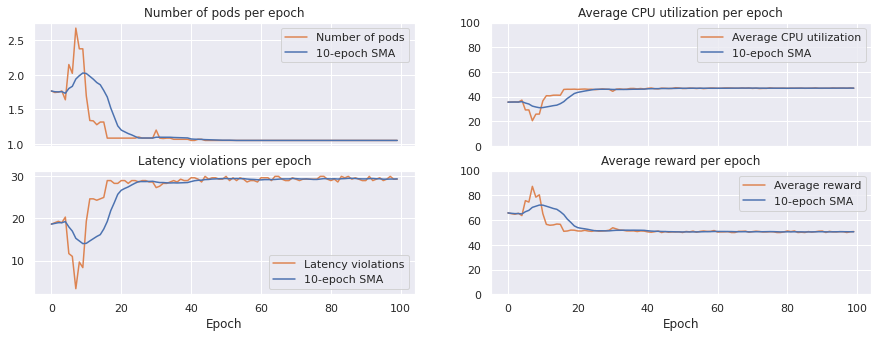

In [6]:
plot_data(epoch_data_mean[:100], epoch_data_sum[:100], sma_10=True)